#### Introduction

Welcome to your MS-Refinitiv Hackathon. This notebook is intended to be a quick start guide to help you get your data as easily as possible. 

Once you have logged into Eikon or Workspace you can get started coding very easily by launching the CODEBOOK APP by typing CODEBK into the search bar or launcher. This wiil spin up a new instance with all the python libraries we have available. 

#### Now how to go about finding data?

For the best experience we recommend the CODE BUILDER app or the DATA ITEM BROWSER app. These tools can help you navigate the wealth of content you have access to in Eikon:

|Category               |Category                       |Category                       |
|:----------------------|:------------------------------|:------------------------------|
|Real Time              |Reference & Identifiers        |Issuer Level Credit Ratings    |
|Price & Volume         |IBES Estimates                 |Starmine Models & Analytics    |
|Corporate Actions      |Mergers & Acquisitions         |Events                         |
|Mutual Fund Holdings   |Equity Index Information       |Economic Indicators            |
|Lipper Funds           |Gov/Corp Bonds                 |US Munis                       |
|MBS                    |CMO/ABS Tranche                |Single Name CDS                |
|Index CDS              |Commodities/Physical Assets    |Warrants                       |
|Ownership              |Portfolio                      |Fundamentals                   |
|Timeseries Data        |Activism & Defence             |Deals                          |
|ESG Data               |Exchange Traded Products       |Prop Data                      |
|Company Fundamentals   |Sales/Trading Calc Analytics   |Private Equity                 |
|Stock Reports Plus     |Financial Markets Master       |                               |

**plus news - please see section on those API calls below**

#### COVID-19 Data

Our Covid-19 data is conveniently stored in a set of real-time economic indicator RICs. 
There are a 5 types of measures, Active Cases, Total Cases, Deaths, New Cases, Recovered. Each of these can be accessed by different country or regions. The easiest way is to look at the MACROVIT app. 

The five types of data are ACOV, CCOV, DCOV, NCOV, RCOV respectively. They are prefixed by either country or region codes and suffixed by =ECI.

So to get data for Italy our RICs would be: ITACOV=ECI, ITCCOV=ECI, ITDCOV=ECI, ITNCOV=ECI, ITRCOV=ECI

To get global data our RICS would be XWACOV=ECI, XWCCOV=ECI, XWDCOV=ECI, XWNCOV=ECI, XWRCOV=ECI

To get the codes for any country or region just use the MACROVIT app and update the main chart with the country or region you want then you will see the 2 digit code to use. 

#### Economic Data

Please see this [article](https://developers.refinitiv.com/en/article-catalog/article/using-economic-indicators-with-eikon-data-api-a-machine-learning-example) about finding and using economic timeseries

#### How to go about finding Instruments?

Its really easy to build up lists of instruments simply using the search bar. Refinitiv also maintains a series of chain RICs that can be used to call futures and options chains as well as Index constituents. For example, the RIC for the FTSE-100 index is .FTSE. In order to get the constituents for that index just put a 0# infront of the index eg. 0#.FTSE. In this way you can very quickly build larger coverage lists.

#### Putting it all together

Above we have covered getting a list of instruments and also list of fields. So lets get started by building some datasets using our APIs.


In [1]:
import refinitiv.dataplatform.eikon as ek
import datetime
from IPython.display import HTML
import numpy as np
import pandas as pd
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

Lets get some covid-19 TimeSeries data using the get_timeseries API call - note for Economic Timeseries we do not put a field into the API call:

In [2]:
df = ek.get_timeseries(['ITACOV=ECI', 'ITCCOV=ECI', 'ITDCOV=ECI', 'ITNCOV=ECI', 'ITRCOV=ECI'],
                       start_date='2020-02-01',end_date='2020-10-13',interval='daily',)
df

VALUE,ITACOV=ECI,ITCCOV=ECI,ITDCOV=ECI,ITNCOV=ECI,ITRCOV=ECI
Date,,,,,
2020-02-24,213,221,7,221,1
2020-02-25,302,314,11,93,1
2020-02-26,377,392,12,78,3
2020-02-27,580,642,17,250,45
2020-02-28,813,880,21,238,46
...,...,...,...,...,...
2020-10-09,70110,343770,36111,5372,237549
2020-10-10,74829,349494,36140,5724,238525
2020-10-11,79075,354950,36166,5456,239709


Pretty straightforward - however we do apply API limits to each call - you can see those limits detailed [here](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation). In short limits per API call are as follows:

Datapoints returned per request - A datapoint is a 'cell', or a unique field value for a unique instrument on a unique time stamp. Datapoint limits vary by the content set being retrieved (for example, timeseries limits are different from news headline limits), but all are throttled on a per request basis and are not aggregated across all applications. Here are Datapoint limit examples per Eikon Data API function type 

**get_data**: The current limit value (10-Oct-2019) is around **10,000 data points**. 

**get_timeseries**: The current limit value (10-Oct-2019) is **3,000 data points (rows) for interday intervals** and **50,000 data points for intraday intervals**. This limit applies to the whole request, whatever the number of requested instrument.

**get_news_headlines**: The current limit value (10-Oct-2019) is **100 headlines per request**. The depth of history is 15 month.

**get_news_story**: The current limit value (10-Oct-2019) is **1 story per request**.

**get_symbology**: **No enforced limit** (10-Oct-2019).

Daily Limits

**Requests per day** - The number of requests sent to the platform per day via the Eikon Data APIs cannot exceed this limit. This number of requests is counted across all client applications connected to the same Eikon instance.The current limit value (10-Oct-2019) is **10,000 requests per day**.

**Response volume per day** - The volume (size) of data retrieved from the platform per day cannot exceed this limit. This volume of data is counted across all client applications connected to the same Eikon instance.The current limit value (10-Oct-2019) is **5 GB per day**.

#### Getting data from Eikon/Workspace
Therefore we have to employ iterative API calls if we want to build larger dataframes whilst staying within API call limits. Here we will build a list of closing prices for the FTSE-100 for the last 10 years. As the get_timeseries call does not accept chain RICs we will first get the constituents of the FTSE-100 using a chain RIC and a get_data function.

#### Get constituents of an Index

In [3]:
ricList,err = ek.get_data('0#.FTSE','CF_NAME')
ricList

,Instrument,CF_NAME
0,STAN.L,STAND.CHART.
1,CRDA.L,CRODA INTL.
2,ANTO.L,ANTOFAGASTA
3,MRW.L,MORRISON (WM)
4,BNZL.L,BUNZL
...,...,...
96,ULVR.L,UNILEVER
97,OCDO.L,OCADO
98,LSE.L,LON.STK.EXCH
99,TSCO.L,TESCO


#### get_timeseries loop with error handling
We can now use the instrument column of the dataframe as a list to iterate over for our get_timeseries API call. The get_timeseries data model only provides Open,High,Low,Close,Volume,Count fields. Here we just request a close.

In [4]:
import time
instruments = ricList['Instrument'].astype(str).values.tolist()

s = '2010-01-06'
e = '2020-10-13'
inv = 'daily'

data1 = pd.DataFrame()

for i in instruments:
    succeed = False
    for attempt in range(10):
        while succeed == False:
            try:
                df1 = ek.get_timeseries(i,  # RICs
                    fields=['CLOSE'],  # fields to be retrieved
                    start_date=s,  # start time
                    end_date=e,  # end time
                    interval=inv)
                df1.rename(columns = {'CLOSE': i}, inplace = True)
                if len(data1):
                    data1 = pd.concat([data1, df1], axis=1)
                else:
                    data1 = df1
                succeed = True
            except:
                time.sleep(0.1)
            else:
                break
        else:
            var = "p"
data1

,STAN.L,CRDA.L,ANTO.L,MRW.L,BNZL.L,SGE.L,SVT.L,BLND.L,ICAG.L,REL.L,...,RDSa.L,FERG.L,ICP.L,BAES.L,DCC.L,ULVR.L,OCDO.L,LSE.L,TSCO.L,LGEN.L
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,1485.034145,824.754203,1038.0,262.191076,660.0,226.058168,1083.0,457.9,NaN,508.0,...,1930.5,1435.864625,294.342982,371.4,1783.713916,1955.0,NaN,660.001109,412.05,80.10
2010-01-07,1471.279583,835.764271,1023.0,267.692915,663.0,229.659094,1072.0,458.7,NaN,502.5,...,1926.5,1487.559972,296.953118,371.5,1809.564843,1931.0,NaN,666.449131,412.00,81.80
2010-01-08,1489.160513,835.263813,1024.0,270.159257,663.5,229.959171,1084.0,461.4,NaN,506.0,...,1910.0,1517.100170,297.153897,368.5,1822.490306,1936.0,NaN,651.710795,415.95,84.30
2010-01-11,1457.983507,836.264729,1020.0,275.281658,674.0,230.059197,1091.0,473.4,NaN,504.0,...,1927.0,1504.440085,296.149999,367.4,1809.564843,1930.0,NaN,656.777098,417.85,82.55
2010-01-12,1421.304677,820.750542,1001.0,278.317156,658.5,229.959171,1089.0,473.6,NaN,502.5,...,1896.0,1526.595234,292.937524,366.3,1792.330892,1929.0,NaN,641.117616,421.00,82.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-07,375.800000,6298.000000,1000.5,169.500000,2519.0,714.200000,2467.0,360.1,97.50,1676.0,...,969.7,8046.000000,1299.000000,493.5,5368.000000,4800.0,2491.0,8868.000000,212.60,198.90
2020-10-08,382.100000,6338.000000,1002.0,170.050000,2496.0,719.800000,2487.0,367.3,107.50,1681.5,...,995.6,8034.000000,1350.000000,492.7,5392.000000,4813.0,2460.0,8844.000000,215.70,199.50
2020-10-09,376.800000,6316.000000,1014.5,172.650000,2480.0,720.800000,2476.0,378.6,103.50,1693.0,...,1016.4,8048.000000,1364.000000,498.3,5402.000000,4847.0,2382.0,8880.000000,219.60,198.35


#### Geting fundamental data (estimates in this case)
Next lets have a look at getting some estimate data for say 'VOD.L'. All fundamental fields can be accessed using the get_data API call. This API also accepts chain RICs as a parameter. However, we may still want to process RICs individually to avoid running into data limits.

In [5]:
df, err = ek.get_data('VOD.L',fields = 
                      ["TR.RevenueMean.calcdate","TR.RevenueMean","TR.EBITMean","TR.PreTaxProfitMean",
                       "TR.NetProfitMean","TR.EPSMean","TR.DPSMean"],
                      parameters={'SDate':'0','EDate':'-199','Period':'FY1','Frq':'D'})

df

,Instrument,Calc Date,Revenue - Mean,EBIT - Mean,Pre-Tax Profit - Mean,Net Income - Mean,Earnings Per Share - Mean,Dividend Per Share - Mean
0,VOD.L,2020-10-14,43290269350,4227172880,2941507130,1757953590,0.06600,0.08959
1,VOD.L,2020-10-13,43290269350,4227172880,2941507130,1757953590,0.06600,0.08959
2,VOD.L,2020-10-12,43290269350,4227172880,2941507130,1757953590,0.06600,0.08959
3,VOD.L,2020-10-09,43297978250,4230872710,2945438190,1760718180,0.06605,0.08959
4,VOD.L,2020-10-08,43297978250,4230872710,2945438190,1760718180,0.06605,0.08959
...,...,...,...,...,...,...,...,...
195,VOD.L,2020-01-08,45156269680,4643598000,3303442210,2095297430,0.07737,0.09597
196,VOD.L,2020-01-07,45156269680,4643598000,3303442210,2095297430,0.07737,0.09597
197,VOD.L,2020-01-06,45156269680,4627685630,3303442210,2095297430,0.07737,0.09597
198,VOD.L,2020-01-03,45156269680,4627685630,3320546070,2114944270,0.07821,0.09597


In [6]:
df['Calc Date']=pd.to_datetime(df['Calc Date'])
df.set_index('Calc Date',inplace=True)
df.sort_values(by=['Calc Date'],ascending=True,inplace=True)
df

,Instrument,Revenue - Mean,EBIT - Mean,Pre-Tax Profit - Mean,Net Income - Mean,Earnings Per Share - Mean,Dividend Per Share - Mean
Calc Date,,,,,,,
2020-01-02,VOD.L,45156269680,4627685630,3320546070,2114944270,0.07821,0.09597
2020-01-03,VOD.L,45156269680,4627685630,3320546070,2114944270,0.07821,0.09597
2020-01-06,VOD.L,45156269680,4627685630,3303442210,2095297430,0.07737,0.09597
2020-01-07,VOD.L,45156269680,4643598000,3303442210,2095297430,0.07737,0.09597
2020-01-08,VOD.L,45156269680,4643598000,3303442210,2095297430,0.07737,0.09597
...,...,...,...,...,...,...,...
2020-10-08,VOD.L,43297978250,4230872710,2945438190,1760718180,0.06605,0.08959
2020-10-09,VOD.L,43297978250,4230872710,2945438190,1760718180,0.06605,0.08959
2020-10-12,VOD.L,43290269350,4227172880,2941507130,1757953590,0.06600,0.08959


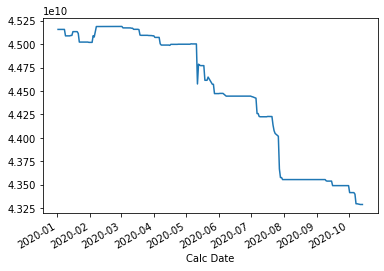

In [7]:
%matplotlib inline
df['Revenue - Mean'].plot()

#### get_news_headlines & get_news_story API calls

Eikon carries 15 months worth of News that you can retrieve via API. The first API call to use is get_news_story and this requires a query term at minimum and returns a maximum of 100 headlines per API call. The query can be generated using the NEWS Monitor app (type NEWS into eikon search bar). This returns a dataframe containing the news headlines from the query along with the storyID which provides access to the underlying story text, using the get_news_story API call. In the example below I calculate the maximum historical range for the news (-15 months, maxenddate) and can then iterate updating the start date from the minimum date contained in the returned news dataframe, as I progress, upto our maxenddate.

In [8]:
import datetime
from datetime import datetime
import dateutil.relativedelta
now = datetime.now()
maxenddate = now - dateutil.relativedelta.relativedelta(months=15)
print(now, maxenddate)

2020-10-15 16:48:24.630168 2019-07-15 16:48:24.630168


In [9]:
newsdf = pd.DataFrame()
startdf=now
while startdf >= maxenddate:
    try:
        df1 = ek.get_news_headlines(query ='R:ADBE.O AND Language:LEN', date_to = startdf, count=100)
        startdf = df1['versionCreated'].min().replace(second=0,microsecond=0,tzinfo=None).strftime('%Y/%m/%d %H:%M')
        startdf = datetime.strptime(startdf,'%Y/%m/%d %H:%M')
        if len(df1):
            newsdf = pd.concat([newsdf, df1], axis=0)
        else:
            newsdf = df1
    except Exception:
        break

newsdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1633 entries, 2020-10-13 12:22:37.865000 to 2019-07-16 15:57:59
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   versionCreated  1633 non-null   datetime64[ns, UTC]
 1   text            1633 non-null   string             
 2   storyId         1633 non-null   string             
 3   sourceCode      1633 non-null   string             
dtypes: datetime64[ns, UTC](1), string(3)
memory usage: 63.8 KB


So we now have our dataframe full of news articles - we can now get the story text for each article by iterating over the frame. **BEWARE: The get_news_story API only allows 1 storyID per API call. You are only allowed 10k API calls per day in total- your key cannot be reset until the next day - so BE CAREFUL HOW YOU USE THEM!**

In [10]:
df3 = ek.get_news_story(newsdf['storyId'][0])
HTML(df3)

I hope this is of use - beware of the API limits - and Happy Hacking :) 

[@jas0nram](https://twitter.com/jas0nram)